# Physical Units Demo

This notebook demonstrates the abilites of the `PhysicalFresnelWavefront` class.

The most important change is that the `wavefront` array now contains values that have units of an actual electric field, i.e. V/m. This is of special importance once non-linear effects are of interest. For example, the thermal blooming effect results from a high-energy laser which heats the air and induces refractive-index changes. For this effect to be implemented, one needs to have the intensity distribution in physical units at disposal. The class `PhysicalFresnelWavefront` is designed to provide exactly this.

An additional functionality is a rudimentary ability to emulate a beam quality factor. This has been done by scaling the wavelength accordingly. The capability to measure the beam quality factor is also implemented. This is useful in cases of arbitrary initial field distributions, where it might not be known.

## Demo 1: Beam Power

The beam power is very easy to apply. However, be careful when to apply a power, since it may result in unexpected behaviour. When the intensity is scaled before applying an aperture for example, the power will change. Let us begin by importing relevant packages and defining some constants.

In [1]:
%matplotlib inline
import poppy
import matplotlib.pyplot as plt
import astropy.units as u

w0 = 10e-2              # beam radius (m)
P0 = 10e3               # beam power (W)
w_extend = 6            # weight of the spatial extend
wavelength = 1064e-9    # wavelength in vacuum (m)
R0 = 100                # initial radius of curvature (m)
npix = 256              # spatial resolution

Now lets define a wavefunction and apply an aperture, lens, and power.

In [2]:
wf = poppy.PhysicalFresnelWavefront(beam_radius=w_extend*w0*u.m,
                                    wavelength=wavelength,
                                    npix=npix,
                                    oversample=2)

wf *= poppy.GaussianAperture(w=w0*u.m)
wf *= poppy.QuadraticLens(f_lens=R0*u.m)

wf.scale_power(P0)

print("P = {0:.2f} kW".format(wf.power*1e-3))

P = 10.00 kW


Next, let us see what happens when we apply the power before the aperture.

In [3]:
wf = poppy.PhysicalFresnelWavefront(beam_radius=w_extend*w0*u.m,
                                    wavelength=wavelength,
                                    npix=npix,
                                    oversample=2)

wf.scale_power(P0)
wf *= poppy.GaussianAperture(w=w0*u.m)
wf *= poppy.QuadraticLens(f_lens=R0*u.m)

print("P = {0:.2f} kW".format(wf.power*1e-3))

P = 0.11 kW


The power values differ from the first result because the power is applied and calculated using the current intensity distribution, which differ as well. So always take care of when to apply the power.

## Demo 2: Beam Quality Factor

We can assign a beam quality factor to the beam which only scaled the wavelength appropriately. However, from the analytical equation for the beam radius one can see that this should work as expected. Let us test it by using the implemented beam quality measurement calculation based on ISO Standard 11146 (see https://www.rp-photonics.com/beam_quality.html)

In [4]:
wf = poppy.PhysicalFresnelWavefront(beam_radius=w_extend*w0*u.m,
                                    wavelength=wavelength,
                                    npix=npix,
                                    oversample=2,
                                    M2=3.827)
wf *= poppy.GaussianAperture(w=w0*u.m)
wf *= poppy.QuadraticLens(f_lens=30*u.cm)
wf.scale_power(P0)

M2, z, caustic, z_fine, w_fit, rayleigh_length = wf.M2()

print("M2 = {0:.2f}".format(M2))

M2 = 3.83


I did not test the algorithm to very large extent, but it worked for my purposes. The results of the $M^2$ fitting routine is shown along with the values used to obtain the fit (red dots) in the following Figure.

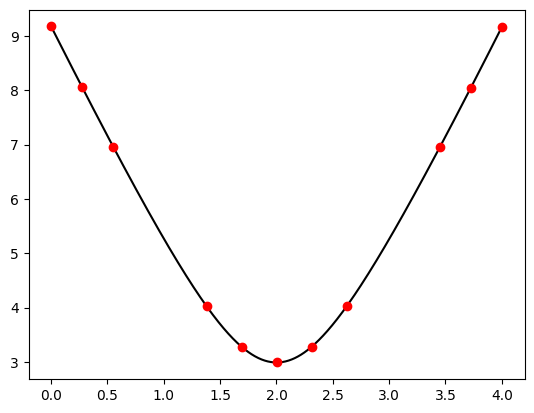

In [5]:
plt.plot((z_fine-z_fine.min())*1e5, w_fit*1e6, '-k')
plt.plot((z-z_fine.min())*1e5, caustic*1e6, 'or')

## Demo 3: Normal propagation

Finally, lets have a quik look on how to propagage by examining the field at the focus and printing the power to the console.

P(0m) = 10.00 kW
r(0m) = 10.00 cm
P(100m) = 9.05 kW
r(100m) = 23.33 cm


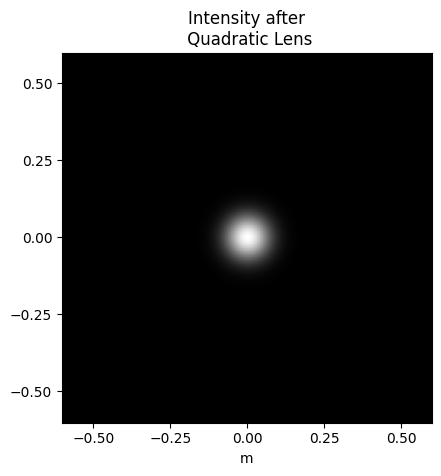

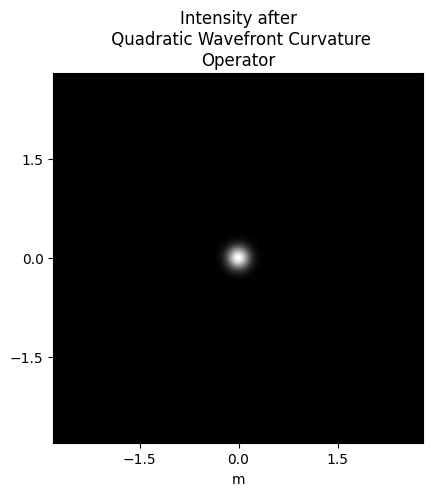

In [6]:
wf = poppy.PhysicalFresnelWavefront(beam_radius=w_extend*w0*u.m,
                                    wavelength=wavelength,
                                    npix=npix,
                                    oversample=2,
                                    M2=3.827)
wf *= poppy.GaussianAperture(w=w0*u.m)
wf *= poppy.QuadraticLens(f_lens=30*u.m)
wf.scale_power(P0)

print("P(0m) = {0:.2f} kW".format(wf.power*1e-3))
print("r(0m) = {0:.2f} cm".format(wf.radius[0]*1e2))

plt.figure(1)
wf.display()

wf.propagate_fresnel(100*u.m, attenuation_coeff=1e-3)

plt.figure(2)
wf.display()

print("P(100m) = {0:.2f} kW".format(wf.power*1e-3))
print("r(100m) = {0:.2f} cm".format(wf.radius[0]*1e2))

## Conclusion

The class `PhysicalFresnelWavefront` implemented an alternative units convention for the electric field and intensity. At the moment, this doesn't change any propagation results. However, if accepted to be included into poppy, I can provide a thermal blooming phase screen (implemented as a `OpticalElement`) which relies on physical units of the intensity because it is a non-linear effect. In its current state, the class does not follow with poppy's conventions, e.g. I did not craft it to use astropy's units package whenever possible. My intent is basically to find out if the community and poppy developers are interested in the capabilites this class provides and features that can build upon it (for example a thermal blooming phase screen).